# Лабораторная работа №4

ФИО:   
Группа: 

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №7 в семестре

Что необходимо сделать:  
- Обучить различные модели глубокого обучения на имеющихся данных  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета 
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии.
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Оформить данные в виде класса `Dataset` из библиотеки `torch` (как мы это делали на семинаре), а затем засунуть в `Dataloader` (тоже делали на семинаре).
5. Обучить на тренировочном множестве:
     1. Очень простую однослойную нейросеть с оптимизатором `SGD` ([link](https://pytorch.org/docs/stable/optim.html)).
     2. Нейросеть посложнее (с 1 скрытым слоем) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
     3. Нейросеть еще сложнее (с 3+ скрытыми слоями) с оптимизатором `Adam` ([link](https://pytorch.org/docs/stable/optim.html)).
6. Посчитайте loss на train и test множествах, в зависимости от эпохи обучения. Провизуализируйте это с помощью библиотеки `matplotlib` (выйдет так называемая **learning curve**, кривая обучения модели).
6. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy
     2. Для задачи регрессии -- MAE
7. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, у вас не будет проблем, просто нужно будет поставить необходимое количество нейронов на выходе вашей нейросети.

## 1. Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

data = pd.read_csv('students_adaptability_level_online_education.csv')
print(f"Размер датасета: {data.shape}")
print(f"\nПервые 5 строк:")
data.head()

Используемое устройство: cpu
Размер датасета: (1205, 14)

Первые 5 строк:


,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


## 2. Определение типа задачи

In [2]:
X = data.drop('Adaptivity Level', axis=1)
y = data['Adaptivity Level']

print("Информация о задаче:")
print(f"Количество признаков: {X.shape[1]}")
print(f"Количество образцов: {X.shape[0]}")
print(f"\nЦелевая переменная: {y.name}")
print(f"Уникальные значения целевой переменной: {y.unique()}")
print(f"Количество классов: {y.nunique()}")
print(f"\nРаспределение классов:")
print(y.value_counts().sort_index())

if y.nunique() == 2:
    task_type = "Бинарная классификация"
elif y.nunique() > 2:
    task_type = "Многоклассовая классификация"
else:
    if pd.api.types.is_numeric_dtype(y):
        task_type = "Регрессия"
    else:
        task_type = "Классификация"

print(f"\nТИП ЗАДАЧИ: {task_type}")

if task_type == "Многоклассовая классификация":
    print(f"\nЭто многоклассовая классификация!")
    print(f"Количество выходных нейронов: {y.nunique()}")


Информация о задаче:
Количество признаков: 13
Количество образцов: 1205

Целевая переменная: Adaptivity Level
Уникальные значения целевой переменной: ['Moderate' 'Low' 'High']
Количество классов: 3

Распределение классов:
Adaptivity Level
High        100
Low         480
Moderate    625
Name: count, dtype: int64

ТИП ЗАДАЧИ: Многоклассовая классификация

Это многоклассовая классификация!
Количество выходных нейронов: 3


## 3. Предобработка данных

### 3.1. Разделение на train и test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в train:")
print(y_train.value_counts().sort_index())
print(f"\nРаспределение классов в test:")
print(y_test.value_counts().sort_index())


Размер тренировочной выборки: (964, 13)
Размер тестовой выборки: (241, 13)

Распределение классов в train:
Adaptivity Level
High         80
Low         384
Moderate    500
Name: count, dtype: int64

Распределение классов в test:
Adaptivity Level
High         20
Low          96
Moderate    125
Name: count, dtype: int64


In [4]:
print("Пропуски в тренировочной выборке:")
missing_train = X_train.isnull().sum()
if missing_train.sum() > 0:
    print(missing_train[missing_train > 0])
else:
    print("Пропусков не обнаружено!")

print("\nПропуски в тестовой выборке:")
missing_test = X_test.isnull().sum()
if missing_test.sum() > 0:
    print(missing_test[missing_test > 0])
else:
    print("Пропусков не обнаружено!")

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nКатегориальные признаки ({len(categorical_cols)}): {categorical_cols}")
print(f"Численные признаки ({len(numerical_cols)}): {numerical_cols}")

if missing_train.sum() > 0:
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
        X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])
    
    if len(numerical_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
        X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])
    
    print("\nПропуски заполнены!")
else:
    print("\nПропусков нет, заполнение не требуется.")


Пропуски в тренировочной выборке:
Пропусков не обнаружено!

Пропуски в тестовой выборке:
Пропусков не обнаружено!

Категориальные признаки (13): ['Gender', 'Age', 'Education Level', 'Institution Type', 'IT Student', 'Location', 'Load-shedding', 'Financial Condition', 'Internet Type', 'Network Type', 'Class Duration', 'Self Lms', 'Device']
Численные признаки (0): []

Пропусков нет, заполнение не требуется.


### 3.3. Нормализация численных признаков


In [5]:
if len(numerical_cols) > 0:
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])
    
    print("Численные признаки нормализованы с помощью StandardScaler")
else:
    print("Численных признаков нет, нормализация не требуется")
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()


Численных признаков нет, нормализация не требуется


### 3.4. Кодирование категориальных признаков


In [6]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_encoded = pd.DataFrame(
    ohe.fit_transform(X_train_scaled[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X_train_scaled.index
)

X_test_encoded = pd.DataFrame(
    ohe.transform(X_test_scaled[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X_test_scaled.index
)

if len(numerical_cols) > 0:
    X_train_final = pd.concat([X_train_encoded, X_train_scaled[numerical_cols]], axis=1)
    X_test_final = pd.concat([X_test_encoded, X_test_scaled[numerical_cols]], axis=1)
else:
    X_train_final = X_train_encoded
    X_test_final = X_test_encoded

print(f"Размерность признаков после кодирования:")
print(f"Train: {X_train_final.shape}")
print(f"Test: {X_test_final.shape}")
print(f"\nКатегориальные признаки закодированы с помощью OneHotEncoder")

le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)

print(f"\nКодирование целевой переменной:")
for i, label in enumerate(le_y.classes_):
    print(f"  {label} -> {i}")

num_classes = len(le_y.classes_)
input_size = X_train_final.shape[1]
print(f"\nРазмерность входных данных: {input_size}")
print(f"Количество классов: {num_classes}")


Размерность признаков после кодирования:
Train: (964, 22)
Test: (241, 22)

Категориальные признаки закодированы с помощью OneHotEncoder

Кодирование целевой переменной:
  High -> 0
  Low -> 1
  Moderate -> 2

Размерность входных данных: 22
Количество классов: 3


## 4. Создание Dataset и DataLoader


In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values if isinstance(X, pd.DataFrame) else X)
        self.y = torch.LongTensor(y) if task_type != "Регрессия" else torch.FloatTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train_final, y_train_encoded)
test_dataset = CustomDataset(X_test_final, y_test_encoded)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset и DataLoader созданы")
print(f"Размер батча: {batch_size}")
print(f"Количество батчей в train: {len(train_loader)}")
print(f"Количество батчей в test: {len(test_loader)}")


Dataset и DataLoader созданы
Размер батча: 32
Количество батчей в train: 31
Количество батчей в test: 8


## 5. Обучение моделей

### 5.1. Простая однослойная нейросеть с SGD


In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        return out

model1 = SimpleNN(input_size, num_classes).to(device)
print("Модель 1 (простая однослойная):")
print(model1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01)

num_epochs = 50
train_losses1 = []
test_losses1 = []

for epoch in range(num_epochs):
    model1.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model1(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model1.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model1(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    train_losses1.append(train_loss / len(train_loader))
    test_losses1.append(test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses1[-1]:.4f}, Test Loss: {test_losses1[-1]:.4f}')

print("\nМодель 1 обучена")


Модель 1 (простая однослойная):
SimpleNN(
  (fc1): Linear(in_features=22, out_features=3, bias=True)
)
Epoch [10/50], Train Loss: 0.8725, Test Loss: 0.8473
Epoch [20/50], Train Loss: 0.8359, Test Loss: 0.8123
Epoch [30/50], Train Loss: 0.8176, Test Loss: 0.7861
Epoch [40/50], Train Loss: 0.8050, Test Loss: 0.7674
Epoch [50/50], Train Loss: 0.7856, Test Loss: 0.7533

Модель 1 обучена


### 5.2. Нейросеть с одним скрытым слоем и Adam


In [9]:
class MediumNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=64):
        super(MediumNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model2 = MediumNN(input_size, num_classes, hidden_size=64).to(device)
print("Модель 2 (с одним скрытым слоем):")
print(model2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

train_losses2 = []
test_losses2 = []

for epoch in range(num_epochs):
    model2.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model2(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model2.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model2(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    train_losses2.append(train_loss / len(train_loader))
    test_losses2.append(test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses2[-1]:.4f}, Test Loss: {test_losses2[-1]:.4f}')

print("\nМодель 2 обучена")


Модель 2 (с одним скрытым слоем):
MediumNN(
  (fc1): Linear(in_features=22, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)
Epoch [10/50], Train Loss: 0.7016, Test Loss: 0.6774
Epoch [20/50], Train Loss: 0.5892, Test Loss: 0.5979
Epoch [30/50], Train Loss: 0.5508, Test Loss: 0.5637
Epoch [40/50], Train Loss: 0.4828, Test Loss: 0.5288
Epoch [50/50], Train Loss: 0.4453, Test Loss: 0.4977

Модель 2 обучена


In [10]:
class DeepNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_sizes=[128, 64, 32]):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        out = self.dropout(out)
        
        out = self.fc4(out)
        return out

model3 = DeepNN(input_size, num_classes, hidden_sizes=[128, 64, 32]).to(device)
print("Модель 3 (с тремя скрытыми слоями):")
print(model3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

train_losses3 = []
test_losses3 = []

for epoch in range(num_epochs):
    model3.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model3(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    model3.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model3(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    train_losses3.append(train_loss / len(train_loader))
    test_losses3.append(test_loss / len(test_loader))
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses3[-1]:.4f}, Test Loss: {test_losses3[-1]:.4f}')

print("\nМодель 3 обучена")


Модель 3 (с тремя скрытыми слоями):
DeepNN(
  (fc1): Linear(in_features=22, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch [10/50], Train Loss: 0.5728, Test Loss: 0.5590
Epoch [20/50], Train Loss: 0.4423, Test Loss: 0.4375
Epoch [30/50], Train Loss: 0.3365, Test Loss: 0.3537
Epoch [40/50], Train Loss: 0.2802, Test Loss: 0.3171
Epoch [50/50], Train Loss: 0.2593, Test Loss: 0.2691

Модель 3 обучена


## 6. Learning Curves (кривые обучения)


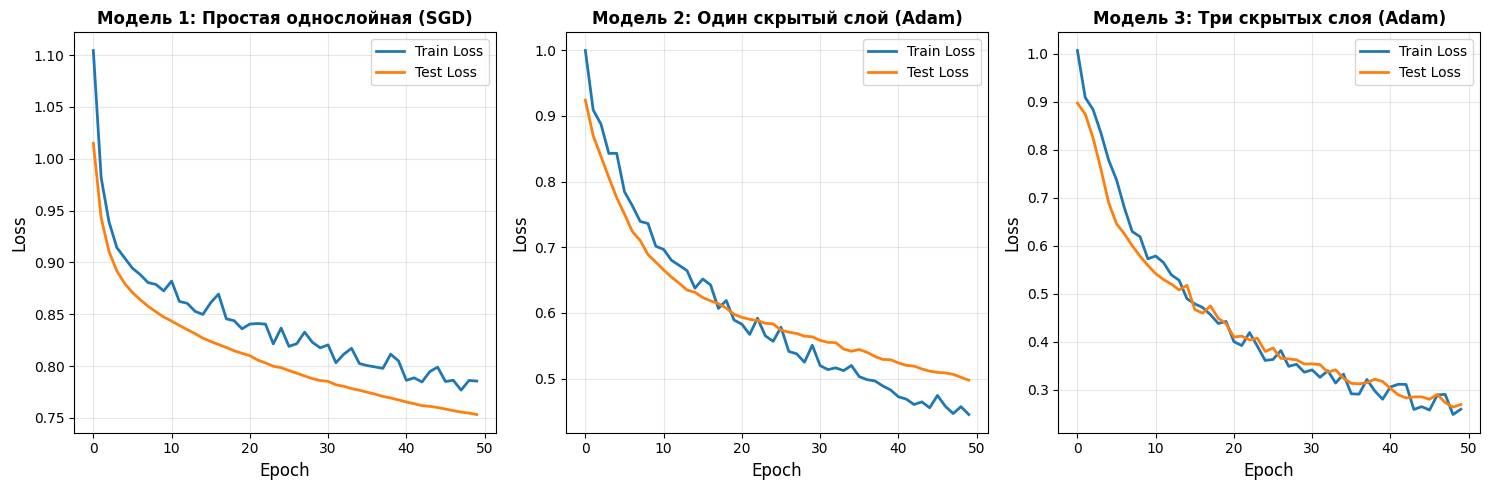

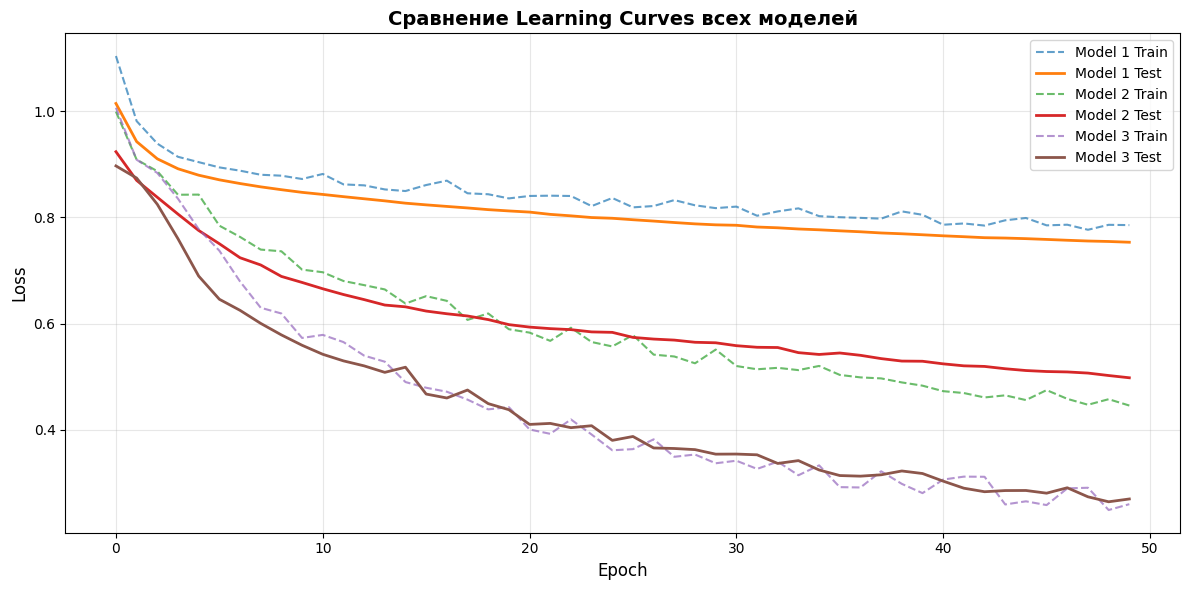

In [11]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses1, label='Train Loss', linewidth=2)
plt.plot(test_losses1, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Модель 1: Простая однослойная (SGD)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_losses2, label='Train Loss', linewidth=2)
plt.plot(test_losses2, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Модель 2: Один скрытый слой (Adam)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(train_losses3, label='Train Loss', linewidth=2)
plt.plot(test_losses3, label='Test Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Модель 3: Три скрытых слоя (Adam)', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(train_losses1, label='Model 1 Train', linestyle='--', alpha=0.7)
plt.plot(test_losses1, label='Model 1 Test', linewidth=2)
plt.plot(train_losses2, label='Model 2 Train', linestyle='--', alpha=0.7)
plt.plot(test_losses2, label='Model 2 Test', linewidth=2)
plt.plot(train_losses3, label='Model 3 Train', linestyle='--', alpha=0.7)
plt.plot(test_losses3, label='Model 3 Test', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Сравнение Learning Curves всех моделей', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Расчет метрик

### 7.1. Accuracy для всех моделей


In [13]:
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

models = {
    'Модель 1 (SimpleNN, SGD)': model1,
    'Модель 2 (MediumNN, Adam)': model2,
    'Модель 3 (DeepNN, Adam)': model3
}

results = {}

for model_name, model in models.items():
    train_preds, train_labels = evaluate_model(model, train_loader)
    test_preds, test_labels = evaluate_model(model, test_loader)
    
    train_acc = accuracy_score(train_labels, train_preds)
    test_acc = accuracy_score(test_labels, test_preds)
    
    results[model_name] = {
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Train Loss': train_losses1[-1] if '1' in model_name else (train_losses2[-1] if '2' in model_name else train_losses3[-1]),
        'Test Loss': test_losses1[-1] if '1' in model_name else (test_losses2[-1] if '2' in model_name else test_losses3[-1])
    }
    
    print(f"{model_name}:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Train Loss: {results[model_name]['Train Loss']:.4f}")
    print(f"  Test Loss: {results[model_name]['Test Loss']:.4f}")
    print()

results_df = pd.DataFrame(results).T
print("Сводная таблица метрик:")
print(results_df.to_string())


Модель 1 (SimpleNN, SGD):
  Train Accuracy: 0.6535
  Test Accuracy: 0.6805
  Train Loss: 0.7856
  Test Loss: 0.7533

Модель 2 (MediumNN, Adam):
  Train Accuracy: 0.8237
  Test Accuracy: 0.7801
  Train Loss: 0.4453
  Test Loss: 0.4977

Модель 3 (DeepNN, Adam):
  Train Accuracy: 0.9212
  Test Accuracy: 0.8714
  Train Loss: 0.2593
  Test Loss: 0.2691

Сводная таблица метрик:
                           Train Accuracy  Test Accuracy  Train Loss  Test Loss
Модель 1 (SimpleNN, SGD)         0.653527       0.680498    0.785557   0.753260
Модель 2 (MediumNN, Adam)        0.823651       0.780083    0.445324   0.497677
Модель 3 (DeepNN, Adam)          0.921162       0.871369    0.259338   0.269139


### 7.2. Визуализация метрик


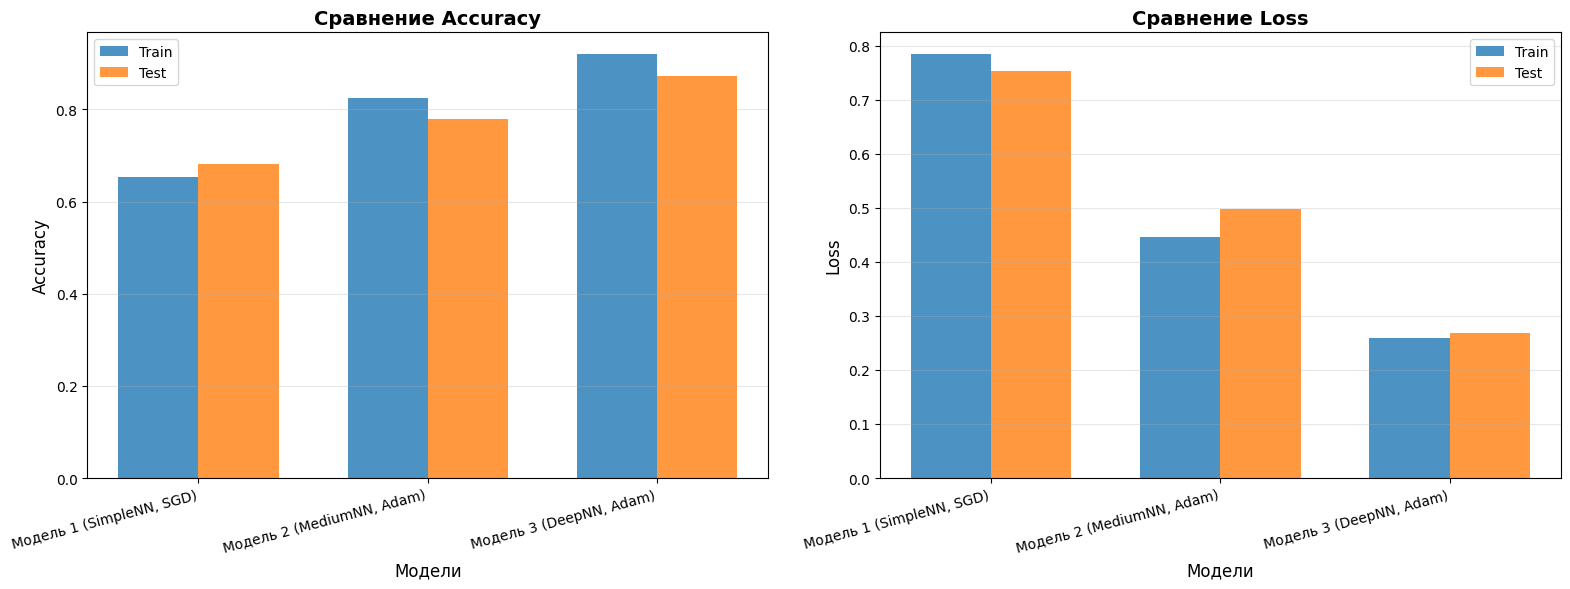

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

model_names = list(results.keys())
x = np.arange(len(model_names))
width = 0.35

ax1 = axes[0]
ax1.bar(x - width/2, results_df['Train Accuracy'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, results_df['Test Accuracy'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Модели', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Сравнение Accuracy', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[1]
ax2.bar(x - width/2, results_df['Train Loss'], width, label='Train', alpha=0.8)
ax2.bar(x + width/2, results_df['Test Loss'], width, label='Test', alpha=0.8)
ax2.set_xlabel('Модели', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Сравнение Loss', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(model_names, rotation=15, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 8. Сравнение моделей и выводы


In [16]:
print("АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ")

best_model_idx = results_df['Test Accuracy'].idxmax()
best_model = results_df.loc[best_model_idx]
best_acc = best_model['Test Accuracy']

print(f"\n1. Какая модель справилась лучше с поставленной задачей?")
print(f"   Лучшая модель: {best_model_idx}")
print(f"   Test Accuracy: {best_acc:.4f}")
print(f"   Test Loss: {best_model['Test Loss']:.4f}")

print(f"\n2. Имеет ли место переобучение?")
overfitting_threshold = 0.05
for model_name in model_names:
    diff = results_df.loc[model_name, 'Train Accuracy'] - results_df.loc[model_name, 'Test Accuracy']
    loss_diff = results_df.loc[model_name, 'Train Loss'] - results_df.loc[model_name, 'Test Loss']
    
    if diff > overfitting_threshold:
        print(f"   [WARNING] {model_name}: Переобучение обнаружено")
        print(f"      Разница Accuracy: {diff:.4f}")
        print(f"      Разница Loss: {loss_diff:.4f}")
    elif diff < -0.01:
        print(f"   [INFO] {model_name}: Небольшое недообучение (разница = {diff:.4f})")
    else:
        print(f"   [OK] {model_name}: Переобучения нет (разница = {diff:.4f})")

print(f"\n3. Имеет ли место недообучение?")
for model_name in model_names:
    if results_df.loc[model_name, 'Test Accuracy'] < 0.6:
        print(f"   [WARNING] {model_name}: Возможно недообучение")
        print(f"      Test Accuracy: {results_df.loc[model_name, 'Test Accuracy']:.4f}")
    else:
        print(f"   [OK] {model_name}: Недообучения нет")
        print(f"      Test Accuracy: {results_df.loc[model_name, 'Test Accuracy']:.4f}")

print(f"\n4. Как можно улучшить метрики моделей?")
print("   Рекомендации:")
print("   • Увеличить количество эпох обучения")
print("   • Настроить learning rate (использовать learning rate scheduler)")
print("   • Попробовать другие архитектуры (BatchNorm, более глубокие сети)")
print("   • Увеличить dropout для борьбы с переобучением")
print("   • Использовать early stopping")
print("   • Попробовать разные оптимизаторы (AdamW, RMSprop)")
print("   • Увеличить размер скрытых слоев")
print("   • Использовать weight decay для регуляризации")
print("   • Попробовать data augmentation (если применимо)")
print("   • Использовать кросс-валидацию для более надежной оценки")


АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ

1. Какая модель справилась лучше с поставленной задачей?
   Лучшая модель: Модель 3 (DeepNN, Adam)
   Test Accuracy: 0.8714
   Test Loss: 0.2691

2. Имеет ли место переобучение?
   [INFO] Модель 1 (SimpleNN, SGD): Небольшое недообучение (разница = -0.0270)
   [OK] Модель 2 (MediumNN, Adam): Переобучения нет (разница = 0.0436)
   [OK] Модель 3 (DeepNN, Adam): Переобучения нет (разница = 0.0498)

3. Имеет ли место недообучение?
   [OK] Модель 1 (SimpleNN, SGD): Недообучения нет
      Test Accuracy: 0.6805
   [OK] Модель 2 (MediumNN, Adam): Недообучения нет
      Test Accuracy: 0.7801
   [OK] Модель 3 (DeepNN, Adam): Недообучения нет
      Test Accuracy: 0.8714

4. Как можно улучшить метрики моделей?
   Рекомендации:
   • Увеличить количество эпох обучения
   • Настроить learning rate (использовать learning rate scheduler)
   • Попробовать другие архитектуры (BatchNorm, более глубокие сети)
   • Увеличить dropout для борьбы с переобучением
   • Использовать ea